In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *

# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

--ip=127.0.0.1


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
parent_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:

df_train = pd.read_csv(os.path.join(parent_dir, 'Data\PreprocessedData\english_train_preprocess.csv'))
df_dev = pd.read_csv(os.path.join(parent_dir, 'Data\PreprocessedData\english_dev_preprocess.csv'))
df_test = pd.read_csv(os.path.join(parent_dir, 'Data\PreprocessedData\english_test_preprocess.csv'))

In [4]:
df_train = df_train[['preprocessed_text', 'label']]
df_dev = df_dev[['preprocessed_text', 'label']]
df_test = df_test[['preprocessed_text', 'label']]

In [5]:
label_replacement = {
    'Hope_speech': 0,
    'Non_hope_speech': 1,
    'not-English': 2,
}

df_train['label'] = df_train['label'].replace(label_replacement)
df_test['label'] = df_test['label'].replace(label_replacement)
df_dev['label'] = df_dev['label'].replace(label_replacement)

# Drop rows with label 2
df_train = df_train[df_train['label'] != 2]
df_test = df_test[df_test['label'] != 2]
df_dev = df_dev[df_dev['label'] != 2]

In [6]:
X_train, y_train = df_train['preprocessed_text'].to_numpy(), df_train['label'].to_numpy()
X_dev, y_dev = df_dev['preprocessed_text'].to_numpy(), df_dev['label'].to_numpy()
X_test, y_test = df_test['preprocessed_text'].to_numpy(), df_test['label'].to_numpy()

In [7]:
t = Tokenizer()
t.fit_on_texts(X_train)

In [8]:
encoded_train = t.texts_to_sequences(X_train)
encoded_dev = t.texts_to_sequences(X_dev)
encoded_test = t.texts_to_sequences(X_test)

In [9]:
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_dev = pad_sequences(encoded_dev, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [10]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(SimpleRNN(24, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             479640    
                                                                 
 simple_rnn (SimpleRNN)      (None, 24)                1176      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 480,841
Trainable params: 480,841
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# fit the model
history = model.fit(
    x=padded_train,
    y=y_train,
    epochs=100,
    validation_data=(padded_dev, y_dev), verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
711/711 [==============================] - 2s 3ms/step - loss: 0.1747 - accuracy: 0.9383 - val_loss: 0.3204 - val_accuracy: 0.8898
Epoch 2/100
711/711 [==============================] - 2s 3ms/step - loss: 0.1574 - accuracy: 0.9449 - val_loss: 0.3301 - val_accuracy: 0.8916
Epoch 3/100
711/711 [==============================] - 2s 3ms/step - loss: 0.1454 - accuracy: 0.9494 - val_loss: 0.3897 - val_accuracy: 0.8592
Epoch 4/100
711/711 [==============================] - 2s 3ms/step - loss: 0.1358 - accuracy: 0.9529 - val_loss: 0.4261 - val_accuracy: 0.8370
Epoch 4: early stopping


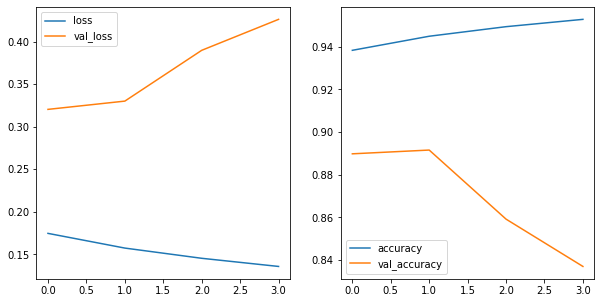

In [16]:
# Plot loss, accuracy, val_loss, val_accuracy
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
plot_history(history)

In [12]:
train_preds = model.predict(padded_train)
dev_preds = model.predict(padded_dev)
test_preds = model.predict(padded_test)

train_preds = np.where(train_preds > 0.5, 1, 0)
dev_preds = np.where(dev_preds > 0.5, 1, 0)
test_preds = np.where(test_preds > 0.5, 1, 0)

train_preds = train_preds.flatten()
dev_preds = dev_preds.flatten()
test_preds = test_preds.flatten()

89/89 [==============================] - 0s 1ms/step


In [13]:
computeAllScores(train_preds, dev_preds, test_preds, False, True)

Accuracy Train:  0.9415127528583993
Accuracy Dev:  0.8975712777191129
Accuracy Test:  0.9029194512838551
Weighted F1 Train:  0.929686210325608
Weighted F1 Dev:  0.872543221313095
Weighted F1 Test:  0.8815297271636542
Macro F1 Train:  0.7417400749396281
Macro F1 Dev:  0.5651130311279442
Macro F1 Test:  0.5683039545784644
Micro F1 Train:  0.9415127528583993
Micro F1 Dev:  0.897571277719113
Micro F1 Test:  0.902919451283855
Weighted Recall Train:  0.9415127528583993
Weighted Recall Dev:  0.8975712777191129
Weighted Recall Test:  0.9029194512838551
Macro Recall Train:  0.677906942858581
Macro Recall Dev:  0.5505410951846679
Macro Recall Test:  0.5528160431932125
Micro Recall Train:  0.9415127528583993
Micro Recall Dev:  0.8975712777191129
Micro Recall Test:  0.9029194512838551
Confusion Matrix Train: 
[[  705  1257]
 [   73 20705]]
Confusion Matrix Dev: 
[[  33  239]
 [  52 2517]]
Confusion Matrix Test: 
[[  32  218]
 [  58 2535]]
